# Historical Baseball Dashboard

### Written by Matthew Parra
Original Date: November 2020

Notebook Updated: June 2022

Twitter: @cursesincode

## This notebook and the application

This notebook will be used to create methods for generating lists of teams based on era as well as lists of players based on era, year, and team. Additionally this notebook will be used to conduct basic analysis as a proof of concept for a dashboard that will analyze Major League Baseball data. In this notebook a baseballs teams win/loss performance as well as batting performance will be evaluated as well as compare two teams. Data will be retrieved from a SQLite database, calculations will be handled using Python and Pandas. All analysis will use the standard built-in methods of plotting data as a means of visualization.

Plotly's Dash will be used when constructing the final application. Because of Plotly's ease of use and flexibility, any further analysis of teams and players that are needed or desired will be designed outside of this notebook. The application will be built using faculty.ai's Dash Bootstrap Components to aid in layout. Using historical MLB (Major League Baseball) data, the application will provide analysis for team and player statistics dating from the earliest years of baseball through the 2021 season.

## Dependencies for the notebook

- SQLite 3
- Pandas

## The Data

The CSV Data used was retrieved from [Seanlahman.com](http://www.seanlahman.com/baseball-archive/statistics/). The CSV data is copyright 1996-2022 by Sean Lahman. The CSV data is licensed under a Creative Commons Attribution-ShareAlike 3.0 Unported License. For details see: [CreativeCommons](http://creativecommons.org/licenses/by-sa/3.0/). The SQLite Database Provided by Nat Dunn of [WebucatorTraining](https://github.com/WebucatorTraining/lahman-baseball-mysql). The SQLite Database is licensed under a Creative Commons Zero v1.0 Universal License. For details see: [Github Repository Licenses](https://docs.github.com/articles/licensing-a-repository/#disclaimer)

In [1]:
# Import Numpy, Pandas, and SQLite libraries
import sqlite3
import pandas as pd
import numpy as np

## From CSV Data to SQL
Using just the CSV data, while more complete, is much more difficult to query using purely Pandas. In some cases the team names had to be altered to their modern counterpart to better fit analysis and provide better continuity. Using SQL to query a SQLite database is speedier and requires less code to run. Using the CSV data, I updated the SQLite database provided by Nat Dunn using the data available in the core of Sean Lahman's CSV data. Using a combination of SQLAlchemy and the SQLite3 libraries to update the database was simple, although, I had to add columns as needed or omit/alter certain columns to make sure the CSV data had all the proper columns needed to fit the SQL database. For the most part, the process of updating the SQLite database looks like this:

```python
# SQLAlchemy engine and SQLite connection both pointed at the same database
alch_engine = create_engine('sqlite:///lahmansbaseballdb.sqlite', echo=False)
sqlite_con = sqlite3.connect('lahmansbaseballdb.sqlite')`

# Query the current state of the SQLite database
sql_teams = pd.read_sql_query(f'''SELECT * FROM teams ORDER BY yearID ASC;''',sqlite_con)
# Validate the latest year in the SQL database, 2019
sql_teams.yearID.max()
# Create a Pandas Dataframe using the CSV files.
teams_csv = pd.read_csv('./core/Teams.csv')
# Validate the latest year in the CSV data, 2021
teams_csv.yearID.max()
# Identify differences in columns
sql_teams.columns.difference(teams_csv.columns)

# Make changes to the columns as needed ...

# Select data, in this case data from 2020 and 2021 needed to be added
teams_csv_data = teams_csv[teams_csv.yearID > 2019]

# Use the Pandas to_sql function and the SQLAlchemy engine to update database
with alch_engine.begin() as connection:
    teams_csv_data.to_sql('teams', con=connection, if_exists='append', index=False)

# New query using the SQLite connection to confirm changes, year should be 2021
update_sql_teams = pd.read_sql_query(f'''SELECT * FROM teams ORDER BY yearID DESC;''',sqlite_con)
update_sql_teams.yearID.max()
```

Although some tables updated without an issue some where more reluctant. The All-Star Full table required replacing rather than updating, the data in the SQL table was replaced by the up-to-date CSV data. A hand full of other tables where left alone either because there was either no new data or no data was available. The tables edited included: Teams, People, Batting, BattingPost, Fielding, FieldingPost, Pitching, PitchingPost, SeriesPost, Managers, HomeGames, and AllstarFull.

### Start a SQLite3 connection to the database

To get started evaluating the data, a connection to the SQLite database will be need.

In [2]:
sqlite_con = sqlite3.connect('lahmansbaseballdb.sqlite')

A fullsize map of the database can be found on Nat Dunn's [GitHub](https://github.com/WebucatorTraining/lahman-baseball-mysql/blob/master/lahman-model.png).

## Listing Teams in Given Era

The history of Major League Baseball (MLB) can be broken into era's, each represents a period of significant change in MLB's history. Plotly Dash requires that dropdown lists use a key value list or rather a 'label' and value list. The following will provide functions that are necessary in dynamically creating a list of team names paired with their ID. I personally called the era prior to the Deadball Era (pre 1903 World Series) the Knickerbocker Era as this is the era and the name of the team that is hailed as the origin of baseball. To begin, we should look at the teams table in the database.

In [3]:
# Query the database for everything in the teams table
teams_table = pd.read_sql_query('SELECT * FROM teams;',sqlite_con)

We already know there will be a lot of data, so it would not be neccesary at this moment to just look at the info function of this dataframe. For now I am just curious about the column names so that I can conduct some exploratory analysis and identify the range of years the database spans and the names of all teams with their ID.

In [4]:
# Take a look at columns
teams_table.columns

Index(['ID', 'yearID', 'lgID', 'teamID', 'franchID', 'divID', 'div_ID',
       'teamRank', 'G', 'Ghome', 'W', 'L', 'DivWin', 'WCWin', 'LgWin', 'WSWin',
       'R', 'AB', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'SB', 'CS', 'HBP', 'SF',
       'RA', 'ER', 'ERA', 'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA',
       'SOA', 'E', 'DP', 'FP', 'name', 'park', 'attendance', 'BPF', 'PPF',
       'teamIDBR', 'teamIDlahman45', 'teamIDretro'],
      dtype='object')

In [5]:
# Investigate how far back the years go
print(f'MLB Baseball spans from {teams_table.yearID.min()} to {teams_table.yearID.max()}, exactly {teams_table.yearID.max() - teams_table.yearID.min()} years.')

MLB Baseball spans from 1871 to 2021, exactly 150 years.


Now that we have confirmed the database is up to date with the most complete season and the database goes as far back as 1871, lets take a quick look at how many teams have played in the 150 years of baseball.

In [6]:
# List all teams from all years
all_teams = pd.read_sql_query('''SELECT DISTINCT team.teamID, team.name
                                    FROM teams team
                                    WHERE team.yearID >= 1871 AND team.yearID <= 2021
                                    ORDER BY team.yearID ASC;''',sqlite_con)

In [7]:
# Take a look at the top 5 in the list
all_teams.head()

,teamID,name
0,BS1,Boston Red Stockings
1,CH1,Chicago White Stockings
2,CL1,Cleveland Forest Citys
3,FW1,Fort Wayne Kekiongas
4,NY2,New York Mutuals


In [8]:
# Count the number of teams
all_teams.name.count()

183

Over the century and a half that baseball has been played we can see that there have been 183 teams that have come and gone, some whom have stood through the test of time and have become pillars in this great sport. Next we will need to create lists of teams based on ranges of years. Because each era will have a set of years associated we can dynamically generate lists of teams with their ID within each selected range.

In [9]:
# Hard coded list of era's to be used with the Dash app
era_list = [{'label': 'Statcast (\'16-\'21)','value': 'Statcast'},
            {'label': 'Post-Steroid (\'06-\'15)','value': 'Post-Steroid'},
            {'label': 'Steroid (\'94-\'05)','value': 'Steroid'},
            {'label': 'Free Agency (\'77-\'93)','value': 'Free Agency'},
            {'label': 'Expantion (\'61-\'76)','value': 'Expantion'},
            {'label': 'Integration (\'42-\'60)','value': 'Integration'},
            {'label': 'Live Ball (\'20-\'41)','value': 'Live Ball'},
            {'label': 'Dead Ball (\'03-\'19)','value': 'Dead Ball'},
            {'label': 'Knickerbocker (\'71-\'02)','value': 'Knickerbocker'},]

# list of of years spanning each era
era_time = [(2016,2021),
            (2006,2015),
            (1994,2005),
            (1977,1993),
            (1961,1976),
            (1942,1960),
            (1920,1941),
            (1903,1919),
            (1871,1902)]

# Creates a dynamic list of team names based on era
def dynamicteams(x):
    # Hardcoded list of era time spans, wouldnt do it this way if the set where larger
    global era_time
    
    # No assertion for the variable X is needed
    # The need to hanel database errors might be needed
    
    # create a filter list of team names and ids
    filter_team_ids = pd.read_sql_query(f'''SELECT DISTINCT team.teamID, team.name
                                        FROM teams team
                                        WHERE team.yearID >= {era_time[x][0]} AND team.yearID <= {era_time[x][1]}
                                        ORDER BY team.yearID ASC;''',sqlite_con)
    # list comp of key value pair
    return [{'label': k, 'value': v }for k, v in zip(filter_team_ids['name'], filter_team_ids['teamID'])]

### List team by ERA

In [10]:
# Select era from list above, in this case the Statcast Era (current era)
era_select = 0
era_list[era_select]

{'label': "Statcast ('16-'21)", 'value': 'Statcast'}

In [11]:
# Display list of teams
dynamicteams(era_select)

[{'label': 'Baltimore Orioles', 'value': 'BAL'},
 {'label': 'Boston Red Sox', 'value': 'BOS'},
 {'label': 'Chicago White Sox', 'value': 'CHA'},
 {'label': 'Cleveland Indians', 'value': 'CLE'},
 {'label': 'Detroit Tigers', 'value': 'DET'},
 {'label': 'Houston Astros', 'value': 'HOU'},
 {'label': 'Kansas City Royals', 'value': 'KCA'},
 {'label': 'Los Angeles Angels of Anaheim', 'value': 'LAA'},
 {'label': 'Minnesota Twins', 'value': 'MIN'},
 {'label': 'New York Yankees', 'value': 'NYA'},
 {'label': 'Oakland Athletics', 'value': 'OAK'},
 {'label': 'Seattle Mariners', 'value': 'SEA'},
 {'label': 'Tampa Bay Rays', 'value': 'TBA'},
 {'label': 'Texas Rangers', 'value': 'TEX'},
 {'label': 'Toronto Blue Jays', 'value': 'TOR'},
 {'label': 'Arizona Diamondbacks', 'value': 'ARI'},
 {'label': 'Atlanta Braves', 'value': 'ATL'},
 {'label': 'Chicago Cubs', 'value': 'CHN'},
 {'label': 'Cincinnati Reds', 'value': 'CIN'},
 {'label': 'Colorado Rockies', 'value': 'COL'},
 {'label': 'Los Angeles Dodgers', '

### Select ERA from List

In [12]:
# Set list of teams to be chosen from
team_list = dynamicteams(era_select)
# Team is selected from a dropdown list using Dash
# OAKLAND ATHLETICS
team = team_list[10]
team

{'label': 'Oakland Athletics', 'value': 'OAK'}

### Get team information

Now that we have obtained a list of teams based on a given era (modern Statcast) and selected the Oakland Athletics, we can query the database for basic information about the team.

In [13]:
# Team championship list and datatable
# team.get('value') is only used here, Dash will have its own way of selecting team in callback
team_info = pd.read_sql_query(f'''SELECT 
                                    team.yearID, team.name, team.lgID, team.divID,
                                    team.park, team.attendance, 
                                    team.Ghome, team.DivWin, 
                                    team.WCWin, team.LgWin, team.WSWin
                                FROM teams team
                                WHERE team.teamID = '{team.get('value')}' 
                                    AND team.yearID >= {era_time[era_select][0]} 
                                    AND team.yearID <= {era_time[era_select][1]}
                                ORDER BY team.yearID ASC;''',sqlite_con)

In [14]:
# Basic team information
print('League:', *team_info.lgID.unique())
print('Division:', *team_info.divID.unique())
print('Park Name(s):', *team_info.park.unique())
# Avgerage Home Attendence
print('Avg. Home Attendence:', (sum(team_info.attendance/team_info.Ghome)/team_info.yearID.count()).round())
# Post-Season accomplishments
print('WC Series Wins: ', team_info[team_info.WCWin == 'Y']['WCWin'].count())
print('Div Series Wins: ', team_info[team_info.DivWin == 'Y']['DivWin'].count())
print('Lg Series Wins: ', team_info[team_info.LgWin == 'Y']['LgWin'].count())
print('World Series Wins: ', team_info[team_info.WSWin == 'Y']['WSWin'].count())

League: AL
Division: W
Park Name(s): O.co Coliseum
Avg. Home Attendence: 14268.0
WC Series Wins:  2
Div Series Wins:  1
Lg Series Wins:  0
World Series Wins:  0


## Team Analysis

Each team's performance is analyzed for Wins and Losses, Batting, Fielding, and Pitching. To keep this notebook brief we will only look at a couple queries. Lets look at the Oakland Athletics Win-Loss record over the Statcast Era as well as their batting performance.

In [15]:
team_winloss = pd.read_sql_query(f'''SELECT team.yearID, team.teamID, team.W, team.L
                                FROM teams team
                                WHERE team.teamID = '{team.get('value')}' 
                                    AND team.yearID >= {era_time[era_select][0]} 
                                    AND team.yearID <= {era_time[era_select][1]}
                                ORDER BY team.yearID ASC;''',sqlite_con)

<AxesSubplot:title={'center':'Oakland Athletics Win/Loss'}, xlabel='yearID'>

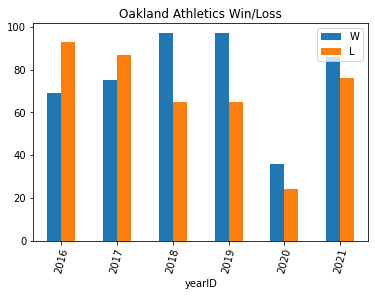

In [16]:
team_winloss[team_winloss.teamID == team.get('value')].plot.bar(x='yearID',y=['W','L'],title=team.get('label') + ' Win/Loss',rot=75)

In [17]:
team_batting = pd.read_sql_query(f'''SELECT team.yearID, team.teamID, team.AB, team.H, team.SO, team.BB, team.HR, team.'2B', team.'3B', team.HBP, team.SF
                                FROM teams team
                                WHERE team.teamID = '{team.get('value')}' 
                                    AND team.yearID >= {era_time[era_select][0]} 
                                    AND team.yearID <= {era_time[era_select][1]}
                                ORDER BY team.yearID ASC;''',sqlite_con)

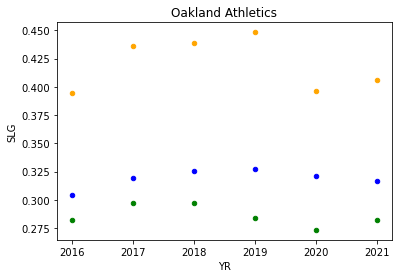

In [18]:
# import matplot lib to plot multiple graphs
import matplotlib.pyplot as plt
# set axis
ax = plt.gca()

# Using the filterd data from above, Live Ball Era
YR = team_batting[team_batting.teamID == team.get('value')].yearID
AB = team_batting[team_batting.teamID == team.get('value')].AB
Ht = team_batting[team_batting.teamID == team.get('value')].H
SO = team_batting[team_batting.teamID == team.get('value')].SO
BB = team_batting[team_batting.teamID == team.get('value')].BB
HR = team_batting[team_batting.teamID == team.get('value')].HR
Db = team_batting[team_batting.teamID == team.get('value')]['2B']
Tr = team_batting[team_batting.teamID == team.get('value')]['3B']
HBP = team_batting[team_batting.teamID == team.get('value')].HBP
SF = team_batting[team_batting.teamID == team.get('value')].SF
# Calculate singles
Sg = Ht - Db - Tr - HR

# Calculate Slugging average
SLG = (Sg + 2*Db + 3*Tr + 4*HR)/AB
# On-Base Percentage
OBP = (Ht + BB + HBP) / (AB + BB + HBP + SF)
# Calculate Batting Average Balls In Play (BABIP)
BABIP = (Ht - HR) / (AB - SO - HR)

# Set graph data
Data = {'YR': YR,
        'BABIP': BABIP,
        'SLG': SLG,
        'OBP': OBP}

# set new dataframe for graph
df = pd.DataFrame(Data,columns=['YR','BABIP','BAVG','SLG','OBP'])
# Apply new dataframe (filtered and calculated data using 'Live Ball' era data)
df.plot.scatter(x='YR', y='BABIP',ax=ax,color='green')
df.plot.scatter(x='YR', y='OBP',ax=ax,color='blue', title=team.get('label'))
df.plot.scatter(x='YR', y='SLG',ax=ax,color='orange')
plt.show()

Looking at the most recent seasons, we see from the win-loss chart, the Athletics have improved their performance while according to the batting performance, they have declined in the past couple years. Perhaps the management had made a trade-off between pitching and hitting. Further analysis would have to be done to make any kind of conclusion. For now we can be sure that our migration to a SQLite database has allowed us to speed up our data retrieval and allow us to focus on analysis over data manipulation. Next lets take a look at comparing two teams.

### Compare two teams

In [19]:
# Select two teams
teamA = team_list[20]
teamB = team_list[10]

In [20]:
teamA

{'label': 'Los Angeles Dodgers', 'value': 'LAN'}

In [21]:
teamB

{'label': 'Oakland Athletics', 'value': 'OAK'}

In [22]:
# Query the database for team data
teamA_winloss = pd.read_sql_query(f'''SELECT team.yearID, team.teamID, team.W, team.L
                                FROM teams team
                                WHERE team.teamID = '{teamA.get('value')}' AND team.yearID >= {era_time[era_select][0]} AND team.yearID <= {era_time[era_select][1]}
                                ORDER BY team.yearID ASC;''',sqlite_con)
teamB_winloss = pd.read_sql_query(f'''SELECT team.yearID, team.teamID, team.W, team.L
                                FROM teams team
                                WHERE team.teamID = '{teamB.get('value')}' AND team.yearID >= {era_time[era_select][0]} AND team.yearID <= {era_time[era_select][1]}
                                ORDER BY team.yearID ASC;''',sqlite_con)

In [23]:
# Calculate the Average Winning Percentage
AwPCT = teamA_winloss.W / (teamA_winloss.W + teamA_winloss.L)
BwPCT = teamB_winloss.W / (teamB_winloss.W + teamB_winloss.L)

In [24]:
# Create an Average Winning Percentage dictionary
AwData = {'Year': teamA_winloss.yearID,
        teamA.get('label'): AwPCT,
        teamB.get('label'): BwPCT}

# Create dataframe from dictionary for graph
Aw_df = pd.DataFrame(AwData,columns=['Year',teamA.get('label'),teamB.get('label')])

<AxesSubplot:xlabel='Year'>

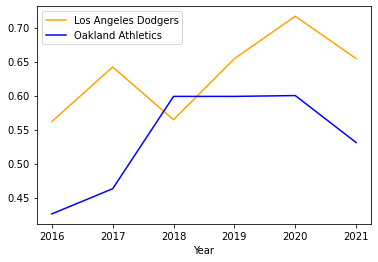

In [25]:
# Plot the Average Winning Percentage of both teams
ax2 = plt.gca()
Aw_df.plot.line(x='Year', y=teamA.get('label'),ax=ax2,color='orange')
Aw_df.plot.line(x='Year', y=teamB.get('label'),ax=ax2,color='blue')

We can see, compared to the Los Angeles Dodgers, the Oakland Athletics continued to work towards improving its performance although they have fallen short with the exception of the 2018 season. Comparing teams will allow us to see how trades and player performances have affected a team over the years. Teams can be compared using various calculations such as their On-Base Plus Slugging average or their Strike-out to Walk ratio or even the more advanced Technical Runs Created. To further the analysis of a given team, taking a look at individual player performance will give us the information we need to understand individual player contributions to a teams performance.

## Player Analysis

While the available teams and their statistics are based on era, available players are provided based on the selected team and year within the given era. The players career data is limited to the given year within the selected era and the beginning of the era. Limiting the player data will provide us with better context to a teams performance through the Era. Players full careers will be evaluated in a separate section of the application. This analysis, however, provides us with an idea of how individual player analysis will be conducted. Analysis consists of Batting and Fielding\Pitching performance other career data such as salaries and accolades may be added as data is available.

In [26]:
# Era list, the same as earlier
# Using a new list here only to ensure nothing is confused
player_era_list = [{'label': 'Statcast (\'16-\'21)','value': 'Statcast'},
            {'label': 'Post-Steroid (\'06-\'15)','value': 'Post-Steroid'},
            {'label': 'Steroid (\'94-\'05)','value': 'Steroid'},
            {'label': 'Free Agency (\'77-\'93)','value': 'Free Agency'},
            {'label': 'Expantion (\'61-\'76)','value': 'Expantion'},
            {'label': 'Integration (\'42-\'60)','value': 'Integration'},
            {'label': 'Live Ball (\'20-\'41)','value': 'Live Ball'},
            {'label': 'Dead Ball (\'00-\'19)','value': 'Dead Ball'},
            {'label': 'Knickerbocker (\'71-\'99)','value': 'Knickerbocker'},]

# Select Era
player_era_select = 0
player_era_list[player_era_select]

{'label': "Statcast ('16-'21)", 'value': 'Statcast'}

In [27]:
# List of teams from the selected era, reusing the same function as earlier
dynamicteams(player_era_select)

[{'label': 'Baltimore Orioles', 'value': 'BAL'},
 {'label': 'Boston Red Sox', 'value': 'BOS'},
 {'label': 'Chicago White Sox', 'value': 'CHA'},
 {'label': 'Cleveland Indians', 'value': 'CLE'},
 {'label': 'Detroit Tigers', 'value': 'DET'},
 {'label': 'Houston Astros', 'value': 'HOU'},
 {'label': 'Kansas City Royals', 'value': 'KCA'},
 {'label': 'Los Angeles Angels of Anaheim', 'value': 'LAA'},
 {'label': 'Minnesota Twins', 'value': 'MIN'},
 {'label': 'New York Yankees', 'value': 'NYA'},
 {'label': 'Oakland Athletics', 'value': 'OAK'},
 {'label': 'Seattle Mariners', 'value': 'SEA'},
 {'label': 'Tampa Bay Rays', 'value': 'TBA'},
 {'label': 'Texas Rangers', 'value': 'TEX'},
 {'label': 'Toronto Blue Jays', 'value': 'TOR'},
 {'label': 'Arizona Diamondbacks', 'value': 'ARI'},
 {'label': 'Atlanta Braves', 'value': 'ATL'},
 {'label': 'Chicago Cubs', 'value': 'CHN'},
 {'label': 'Cincinnati Reds', 'value': 'CIN'},
 {'label': 'Colorado Rockies', 'value': 'COL'},
 {'label': 'Los Angeles Dodgers', '

In [28]:
# Set team list
player_team_list = dynamicteams(player_era_select)

In [29]:
# Select team, LOS ANGELES DODGERS selected
player_team = player_team_list[20]
player_team

{'label': 'Los Angeles Dodgers', 'value': 'LAN'}

Now that the era and team have been selected the teams roster needs to be generated. In the past I generated the roster from here, however, that required the user to poor through a huge list of names. Here I have created functions similar to how the team list is created. So that the user can select from a shorter list, they will have to first select a year from within the selected era to determine which roster is presented.

In [30]:
# Creates a dynamic list of years based on era
def dynamicyears(x):
    # Hardcoded list of era time spans, wouldnt do it this way if the set where larger
    global era_time
    
    # create a filter list of team names and ids
    year_list = [i for i in np.arange(era_time[x][0],era_time[x][1]+1)]

    # list comp of key value pair
    return [{'label': k, 'value': v }for k, v in zip(year_list, year_list)]

In [31]:
# List of years based on selected era
dynamicyears(player_era_select)

[{'label': 2016, 'value': 2016},
 {'label': 2017, 'value': 2017},
 {'label': 2018, 'value': 2018},
 {'label': 2019, 'value': 2019},
 {'label': 2020, 'value': 2020},
 {'label': 2021, 'value': 2021}]

In [32]:
# Set list of years
player_year_list = dynamicyears(player_era_select)

In [33]:
# Select year from list, 2021 selected
player_year_select = 5
player_year = player_year_list[player_year_select]
player_year

{'label': 2021, 'value': 2021}

In [34]:
# create a function to dynamicaly create a list of players based on team and year
def dynamicplayers(team,year):
    # query database for players name and id
    player_list = pd.read_sql_query(f'''SELECT batter.playerID, player.nameFirst || ' ' || player.nameLast AS playerName
                                FROM batting batter
                                    LEFT JOIN people player ON player.playerID = batter.playerID
                                WHERE batter.teamID = '{team.get('value')}' 
                                    AND batter.yearID = {year.get('value')}
                                ORDER BY batter.playerID ASC;''',sqlite_con)
    # Return key value list of players names with id
    return [{'label': k, 'value': v }for k, v in zip(player_list.playerName, player_list.playerID)]

In [35]:
# List players from the 2021 Houston Astros
dynamicplayers(player_team,player_year)

[{'label': 'Scott Alexander', 'value': 'alexasc01'},
 {'label': 'Austin Barnes', 'value': 'barneau01'},
 {'label': 'Trevor Bauer', 'value': 'bauertr01'},
 {'label': 'Matt Beaty', 'value': 'beatyma01'},
 {'label': 'Cody Bellinger', 'value': 'bellico01'},
 {'label': 'Mookie Betts', 'value': 'bettsmo01'},
 {'label': 'Phil Bickford', 'value': 'bickfph01'},
 {'label': 'Justin Bruihl', 'value': 'bruihju01'},
 {'label': 'Walker Buehler', 'value': 'buehlwa01'},
 {'label': 'Andy Burns', 'value': 'burnsan01'},
 {'label': 'Garrett Cleavinger', 'value': 'cleavga01'},
 {'label': 'Neftali Feliz', 'value': 'felizne01'},
 {'label': 'Tony Gonsolin', 'value': 'gonsoto01'},
 {'label': 'Victor Gonzalez', 'value': 'gonzavi02'},
 {'label': 'Brusdar Graterol', 'value': 'gratebr01'},
 {'label': 'Josiah Gray', 'value': 'grayjo03'},
 {'label': 'Conner Greene', 'value': 'greenco01'},
 {'label': 'Shane Greene', 'value': 'greensh02'},
 {'label': 'Andre Jackson', 'value': 'jacksan01'},
 {'label': 'Kenley Jansen', '

In [36]:
# Set roster of players from 2021 Houston Astros
player_roster = dynamicplayers(player_team,player_year)

In [37]:
# Select desired player from roster
player_roster_select = 5
player_select = player_roster[player_roster_select]
player_select

{'label': 'Mookie Betts', 'value': 'bettsmo01'}

### Basic Information

Now that we selected our desired player, Mookie Betts from the 2021 Los Angeles Dodgers, lets retrieve some basic information about our player such as position played, debut, and how the player bats and throws. Since it will be important later, we will also need to calculate the age of the player. However, players who have passed away will need to have their age evaluated differently.

In [38]:
# Query the database for player name, date of birth and other information needed
player_data = pd.read_sql_query(f'''SELECT DISTINCT player.nameFirst || ' ' || player.nameLast AS playerName, player.birth_date, player.bats, player.throws, fielder.pos, debut
                                FROM people player
                                    LEFT JOIN fielding fielder ON fielder.playerID = player.playerID
                                WHERE player.playerID = '{player_select.get('value')}';''',sqlite_con)

In [39]:
# So that we can properly and accurately calculate players ages
# import datetime and timedelta
from datetime import datetime, timedelta

In [40]:
# set todays date
today = datetime.today()

In [41]:
# set selected players birthdate as a datetime timestamp
player_birthdate = pd.to_datetime(player_data.birth_date)

In [42]:
# using the timedelta, calculate the players proper age
player_age = (today - player_birthdate)/timedelta(days=365)

In [43]:
# Print basic information of selected player
print(f'Player Name: {player_data.playerName[0]}')
print(f'Player Current Age: {round(player_age[0])}')
print(f'Debut: {player_data.debut[0]}')
print(f'Bats/Throws: {player_data.bats[0]}/{player_data.throws[0]}')
for position in player_data.POS: print(f'Position: {position}')

Player Name: Mookie Betts
Player Current Age: 30
Debut: 2014-06-29
Bats/Throws: R/R
Position: 2B
Position: OF


### Analysis

With the basic information taken care of, the player data can be retrieved and analyzed. We also need to be sure that the players position is included in the datatable since a single player may play multiple positions but may only play for one team or play on multiple teams but play at various positions. Remember the data that is selected is based on the Era and the year, a players career data will only reflect upto the selected year.

In [44]:
# Query database for player data
player_career = pd.read_sql_query(f'''SELECT batter.yearID, batter.teamID, batter.lgID, batter.G, batter.AB, batter.R, batter.H, batter."2B", batter."3B", 
                                    batter.HR, batter.RBI, batter.SB, batter.CS, batter.BB, batter.SO, batter.IBB, batter.HBP, batter.SH, batter.SF, batter.GIDP
                                FROM batting batter
                                WHERE batter.playerID = '{player_select.get('value')}'
                                    AND batter.yearID >= {era_time[player_era_select][0]} AND batter.yearID <= {player_year.get('value')}
                                ORDER BY batter.yearID ASC;''',sqlite_con)

In [45]:
# Mookie Betts's career statistics during the Statcast Era 2016-2021
player_career

,yearID,teamID,lgID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,2016,BOS,AL,158,672,122,214,42,5,31,113,26,4,49,80,1,2,0,7,12
1,2017,BOS,AL,153,628,101,166,46,2,24,102,26,3,77,79,9,2,0,5,9
2,2018,BOS,AL,136,520,129,180,47,5,32,80,30,6,81,91,8,8,0,5,5
3,2019,BOS,AL,150,597,135,176,40,5,29,80,16,3,97,101,6,3,0,9,11
4,2020,LAN,NL,55,219,47,64,9,1,16,39,10,2,24,38,1,2,0,1,2
5,2021,LAN,NL,122,466,93,123,29,3,23,58,10,5,68,86,2,11,0,5,5


With the datatable, we can see the player was traded from Boston to LA in 2020 which may have contributed to the Dodgers rise in batting performance. Similar to teams analysis, a player can be compared to many other players in various ways. Below is a basic example of analyzing a players batting performance. The plot shows Mookie Betts's On-Base Plus Slugging (OPS), Slugging Average (SLG), and On-Base Percentage (OBP).

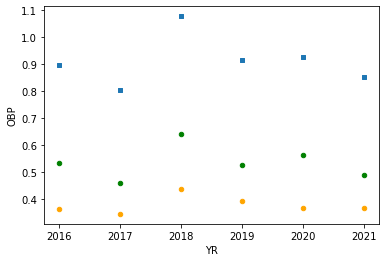

In [46]:
# set axis
ax3 = plt.gca()

# Using the filterd data from above set data variables
# Years
YR = player_career.yearID
# Calculate singles
Single = player_career.H - player_career['2B'] - player_career['3B'] - player_career.HR
# Calculate On-Base Percentage
OBP = (player_career.H + player_career.BB + player_career.HBP) / (player_career.AB + player_career.BB + player_career.HBP + player_career.SF)
# Calculate Slugging average
SLG = (Single + 2*player_career['2B'] + 3*player_career['3B'] + 4*player_career.HR)/player_career.AB
# Calculate On-Base Plus Slugging
OPS = OBP + SLG

# Set graph data
Data = {'YR': YR,
        'OPS': OPS,
        'OBP': OBP,
        'SLG': SLG}

# set new dataframe for graph
df = pd.DataFrame(Data,columns=['YR','OPS','OBP','SLG'])
# plot new dataframe
df.plot.scatter(x='YR', y='OPS',ax=ax3,marker='s')
df.plot.scatter(x='YR', y='SLG',ax=ax3,color='green')
df.plot.scatter(x='YR', y='OBP',ax=ax3,color='orange')

plt.show()

In [47]:
# Since we are done, we must close the database connection.
# Regardless of this being a notebook, its good practice.
sqlite_con.close()

We can see that Mookie Betts's batting performance has remained strong and consistent which makes him a perspective team leader and significant contributor to a teams performance. While comparative analysis can be beneficial to selecting players for a trade. There are more advanced ways to compare a desired player against perspective competition, which may be addressed at a later time. Additionally current player career evaluation and projections can be included, however, projections will be handled in a separate notebook.

## Conclusion

We can see that players and teams can be evaluated using a combination of SQL queries and Pandas. This notebook updated the methods and functions needed to pursue an analytically driven application. The visualizations and data shown in this notebook will be used to create an application using Plotly Dash, analyzing team and player data from across Major League Baseball's history.